Data Analysis and Visualization

In [114]:
'''
Import the necessary libraries
'''
from utils import *
import warnings
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import seaborn as sns



warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Building raw data: Reading from different sources and merging them

In [115]:
'''
Data of daily realized volatility and daily return of S&P 500 index from 2016 to 2023
'''
data = pd.read_csv("Data/SPX/SPX_final_data.csv", index_col=0, parse_dates=True)
data = data.loc['2016':]
data.head()

,rv5,return
2016-01-04,0.018644,-0.015121
2016-01-05,0.007912,0.001960
2016-01-06,0.014094,-0.013133
2016-01-07,0.019777,-0.024133
2016-01-08,0.013277,-0.011079


In [116]:
'''
Aruoba-Diebold-Scotti Index
'''
df = pd.read_csv('Data/Indicators/ADS Index.csv', sep=';', index_col=0)
df.columns = ['ADS']
df.index = pd.to_datetime(df.index, format='%Y:%m:%d')
data = data.merge(df, left_index=True, right_index=True, how='inner')

data.head()

,rv5,return,ADS
2016-01-04,0.018644,-0.015121,-0.294595
2016-01-05,0.007912,0.001960,-0.279636
2016-01-06,0.014094,-0.013133,-0.265093
2016-01-07,0.019777,-0.024133,-0.250960
2016-01-08,0.013277,-0.011079,-0.237233


In [117]:
'''
US Economic Policy Uncertainty Index
'''
df = pd.read_csv('Data/Indicators/Economic Policy Index.csv', index_col=0)
df.index = pd.to_datetime(df.index)
data = data.merge(df, left_index=True, right_index=True, how='inner')

data.head()

,rv5,return,ADS,USEPUINDXD
2016-01-04,0.018644,-0.015121,-0.294595,106.94
2016-01-05,0.007912,0.001960,-0.279636,52.80
2016-01-06,0.014094,-0.013133,-0.265093,30.40
2016-01-07,0.019777,-0.024133,-0.250960,56.40
2016-01-08,0.013277,-0.011079,-0.237233,62.21


In [118]:
'''
Getting data from Yahoo Finance
'''

ticker_names = ['^IRX', '^FVX', '^TYX', '^VIX', 'DX-Y.NYB']
symbol_names = ['13wb', '5yt', '30yt', 'VIX', 'Dollar_index']

for ticker, symbol in zip(ticker_names, symbol_names):
    # Download the data
    data_yahoo = yf.download(ticker, start='2016-01-01', end='2024-12-31')  
    data.index = pd.to_datetime(data.index)
    data_yahoo = data_yahoo[['Close']]
    # Rename the column
    data_yahoo.columns = [symbol]
    # Merge the data with your existing dataframe
    data = data.merge(data_yahoo, left_index=True, right_index=True, how='inner')

data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,rv5,return,ADS,USEPUINDXD,13wb,5yt,30yt,VIX,Dollar_index
2016-01-04,0.018644,-0.015121,-0.294595,106.94,0.155,1.735,2.990,20.700001,98.870003
2016-01-05,0.007912,0.001960,-0.279636,52.80,0.205,1.724,3.011,19.340000,99.400002
2016-01-06,0.014094,-0.013133,-0.265093,30.40,0.205,1.650,2.940,20.590000,99.180000
2016-01-07,0.019777,-0.024133,-0.250960,56.40,0.190,1.612,2.926,24.990000,98.220001
2016-01-08,0.013277,-0.011079,-0.237233,62.21,0.190,1.578,2.920,27.010000,98.540001


In [119]:
'''
Making the credit spread
'''
data['credit_spread'] = data['5yt'] - data['13wb']
data.drop(['5yt', '30yt'], axis=1, inplace=True)

In [120]:
'''
Adding the traded volume of S&P 500 index
'''
data_yahoo = yf.download('^SPX', start='2000-01-01', end='2024-12-31')
# Convert the index to datetime
data_yahoo.index = pd.to_datetime(data_yahoo.index)
data_yahoo = data_yahoo[['Volume']]
data = data.merge(data_yahoo, left_index=True, right_index=True, how='inner')

data.head()

[*********************100%%**********************]  1 of 1 completed


,rv5,return,ADS,USEPUINDXD,13wb,VIX,Dollar_index,credit_spread,Volume
2016-01-04,0.018644,-0.015121,-0.294595,106.94,0.155,20.700001,98.870003,1.580,4304880000
2016-01-05,0.007912,0.001960,-0.279636,52.80,0.205,19.340000,99.400002,1.519,3706620000
2016-01-06,0.014094,-0.013133,-0.265093,30.40,0.205,20.590000,99.180000,1.445,4336660000
2016-01-07,0.019777,-0.024133,-0.250960,56.40,0.190,24.990000,98.220001,1.422,5076590000
2016-01-08,0.013277,-0.011079,-0.237233,62.21,0.190,27.010000,98.540001,1.388,4664940000


In [121]:
'''
Merging the data with the sentiment score
'''
df = pd.read_csv('Data/Sentiment/Sentiment.csv', index_col=['date'])
df.index = pd.to_datetime(df.index)
df = df[['compound_weighted']]
data = data.merge(df, left_index=True, right_index=True, how='left')
# Days without any sentiment score will be filled with 0
data['compound_weighted'] = data['compound_weighted'].fillna(0)

data.head()

,rv5,return,ADS,USEPUINDXD,13wb,VIX,Dollar_index,credit_spread,Volume,compound_weighted
2016-01-04,0.018644,-0.015121,-0.294595,106.94,0.155,20.700001,98.870003,1.580,4304880000,0.022902
2016-01-05,0.007912,0.001960,-0.279636,52.80,0.205,19.340000,99.400002,1.519,3706620000,0.003026
2016-01-06,0.014094,-0.013133,-0.265093,30.40,0.205,20.590000,99.180000,1.445,4336660000,0.002812
2016-01-07,0.019777,-0.024133,-0.250960,56.40,0.190,24.990000,98.220001,1.422,5076590000,0.033178
2016-01-08,0.013277,-0.011079,-0.237233,62.21,0.190,27.010000,98.540001,1.388,4664940000,-0.001335


In [122]:
'''
Rename the columns
'''

data.rename(columns={'rv5': 'Realized Volatility', 'return': 'Return', 'USEPUINDXD':'US Policy Index', '13wb':'13w TB', 'compound_weighted':'Sentiment Score', 'credit_spread': 'term_spread'}, inplace=True)

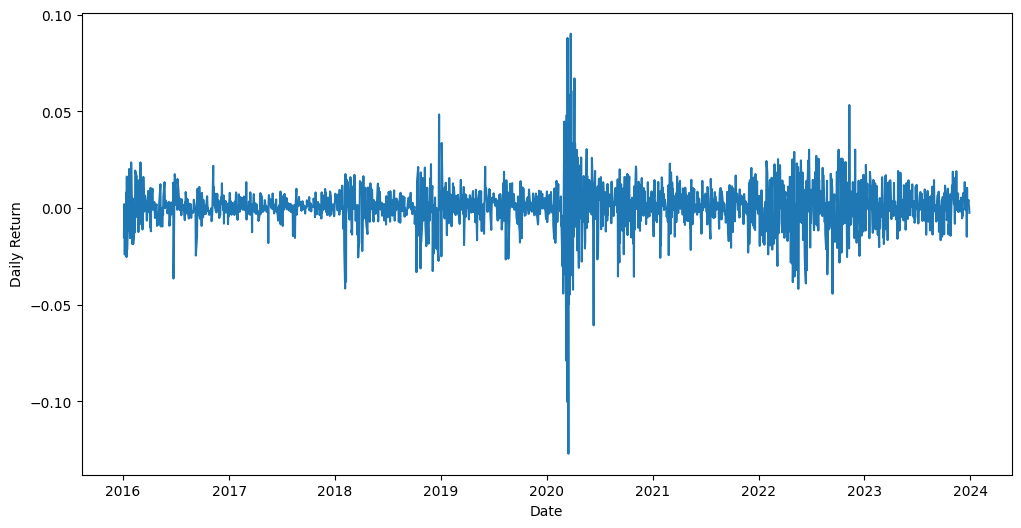

In [123]:
plt.figure(figsize=(12, 6))
plt.plot(data['Return'])
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.savefig("Outputs/Data Visualization/Daily_Return.png")
plt.show()

In [23]:
'''
Saving the raw data
'''
data.to_csv('Data/raw_data.csv')

In [24]:
'''
Function of adding lags to the data
We drop the columns that we add lags to. This is done to prevent data leakage.
'''
def add_lags(data, columns, lags, columns_not_to_drop):
    data = data.copy()
    for column in columns:
        for lag in lags:
            data[column + '_lag_' + str(lag)] = data[column].shift(lag)
    data.dropna(inplace=True)
    for column in columns:
        if column not in columns_not_to_drop:
            data.drop(column, axis=1, inplace=True)
    return data

data_lag_1 = add_lags(data, data.columns, [1], ['Realized Volatility'])
data_lag_1.head()

,Realized Volatility,Realized Volatility_lag_1,Return_lag_1,ADS_lag_1,US Policy Index_lag_1,13w TB_lag_1,VIX_lag_1,Dollar_index_lag_1,term_spread_lag_1,Volume_lag_1,Sentiment Score_lag_1
2016-01-05,0.007912,0.018644,-0.015121,-0.294595,106.94,0.155,20.700001,98.870003,1.580,4.304880e+09,0.022902
2016-01-06,0.014094,0.007912,0.001960,-0.279636,52.80,0.205,19.340000,99.400002,1.519,3.706620e+09,0.003026
2016-01-07,0.019777,0.014094,-0.013133,-0.265093,30.40,0.205,20.590000,99.180000,1.445,4.336660e+09,0.002812
2016-01-08,0.013277,0.019777,-0.024133,-0.250960,56.40,0.190,24.990000,98.220001,1.422,5.076590e+09,0.033178
2016-01-11,0.012732,0.013277,-0.011079,-0.237233,62.21,0.190,27.010000,98.540001,1.388,4.664940e+09,-0.001335


In [25]:
'''
Save data with one lags
'''
data_lag_1.to_csv('Data/raw_data_with_one_lag.csv')

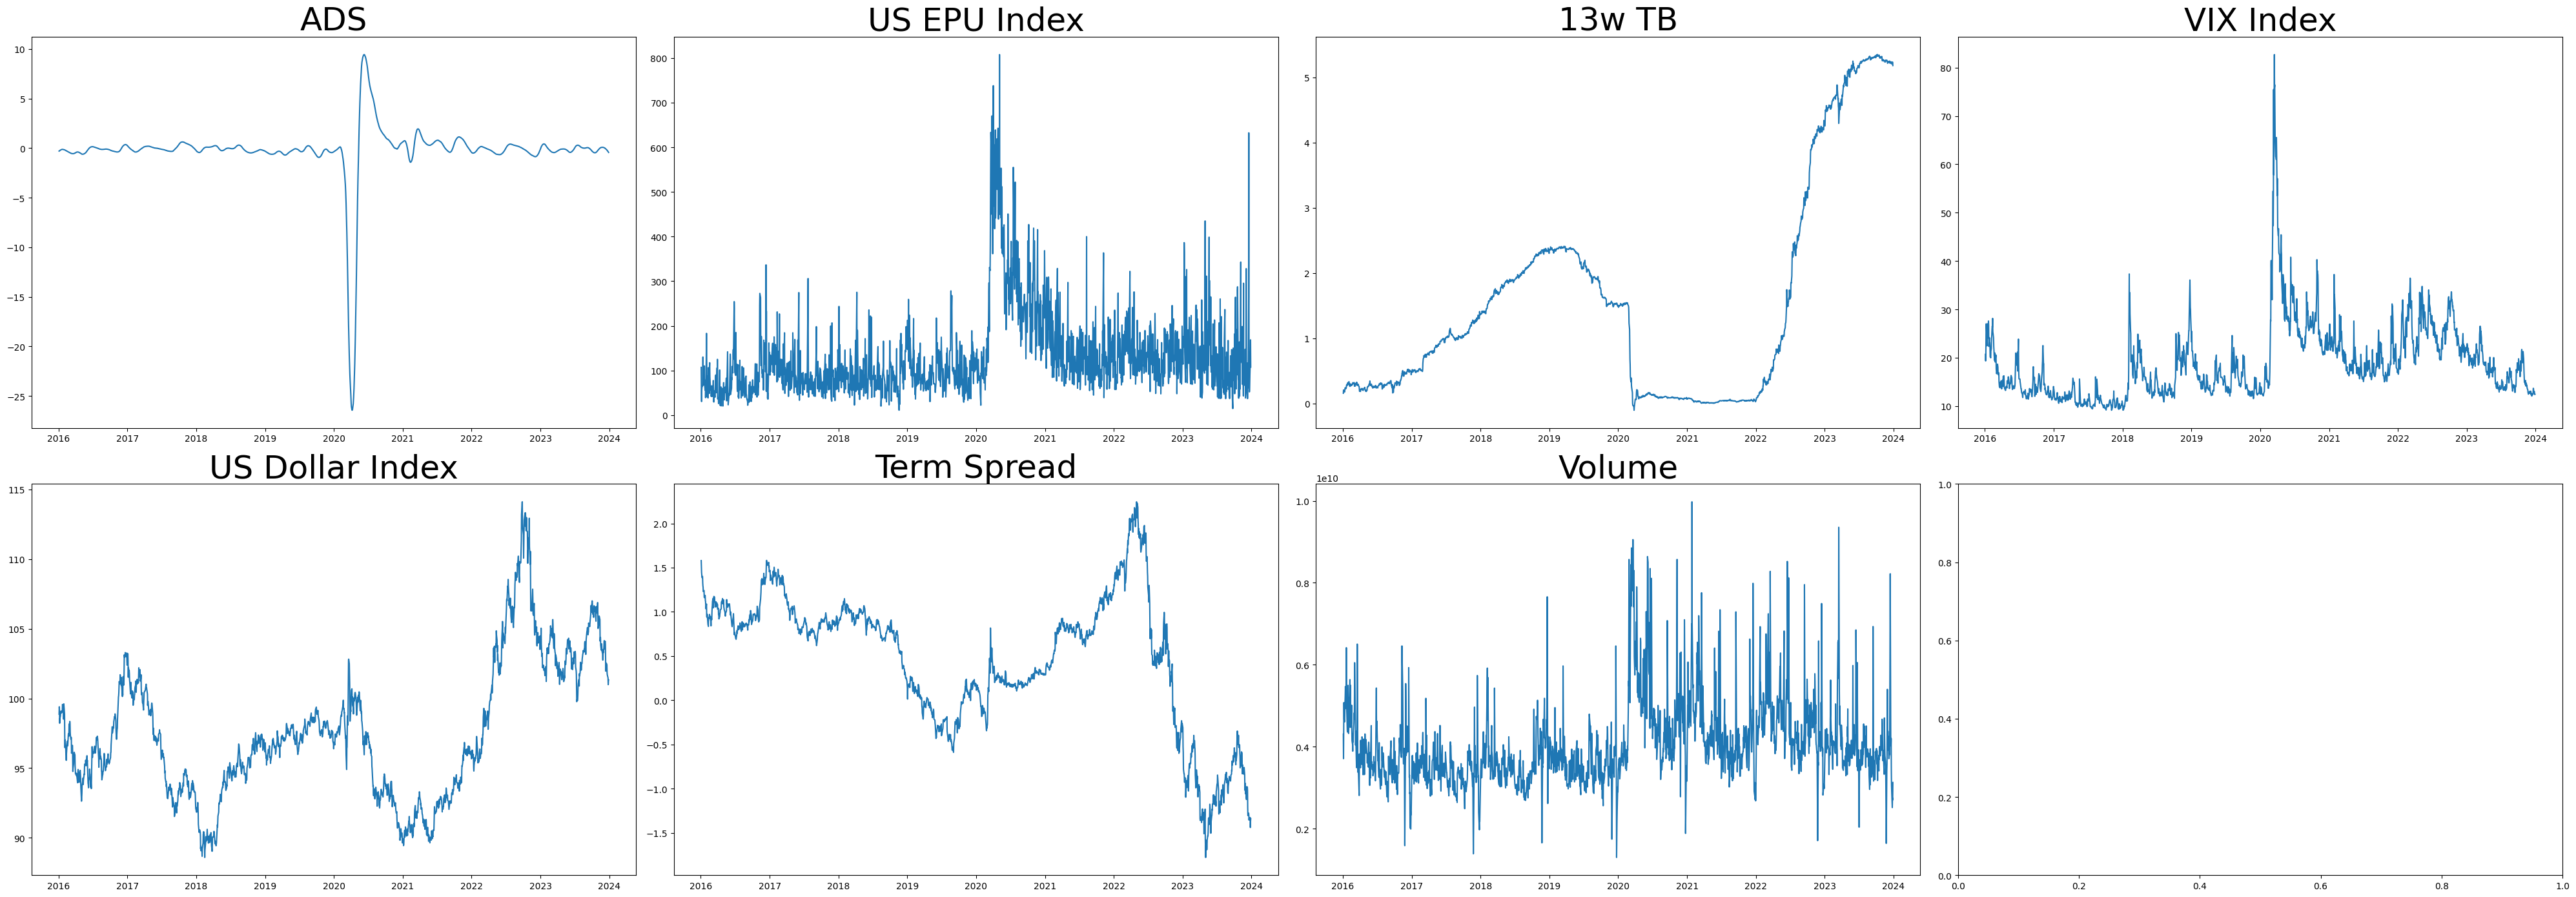

In [26]:
'''
Plot all the columns except Realized Volatility, Sentiment Score, and Return
'''

columns_to_plot = []
for column in data.columns:
    if column not in ["Sentiment Score", "Realized Volatility", "Return"]:
        columns_to_plot.append(column)
column_titles = {'13w TB': '13w TB', 'Dollar_index': 'US Dollar Index', 'term_spread': 'Term Spread', 'VIX': 'VIX Index', 'DX-Y.NYB': 'Dollar Index', 'Volume': 'Volume', 'US Policy Index': 'US EPU Index', 'ADS': 'ADS'}

data_to_plot = data[columns_to_plot]

num_cols = len(data_to_plot.columns)
num_rows = 2  

fig, axs = plt.subplots(num_rows, 4, figsize=(40, num_rows*7))

for ax, column in zip(axs.flatten(), data_to_plot.columns):
    ax.plot(data[column])
    
    ax.set_title(column_titles[column], fontsize=36)

plt.tight_layout()
plt.savefig("Outputs/Data Visualization/Data_plots.png")

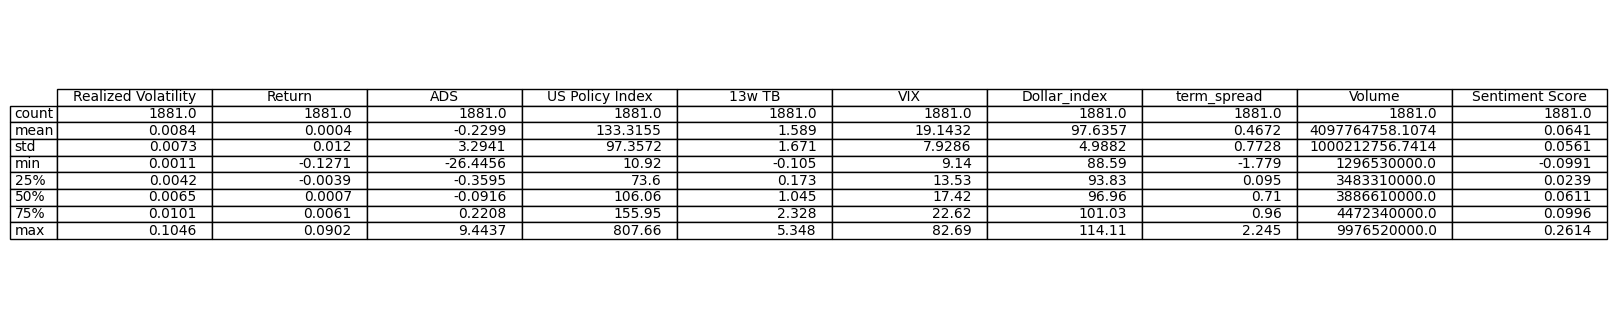

In [124]:
'''
Plot and save the summary stats of all columns
'''
summary_stats = data.describe().round(4)
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Hide axes
ax.axis('off')

# Plot table
table = pd.plotting.table(ax, summary_stats, loc='center', colWidths=[0.2] * len(data.columns))

# Adjust font size for better readability
table.auto_set_font_size(False)
table.set_fontsize(10)

# Save the figure as a PNG image with higher DPI
plt.savefig('Outputs/Data Visualization/summary_stats_figure.png', bbox_inches='tight', dpi=300)

# Show the plot (optional)
plt.show()

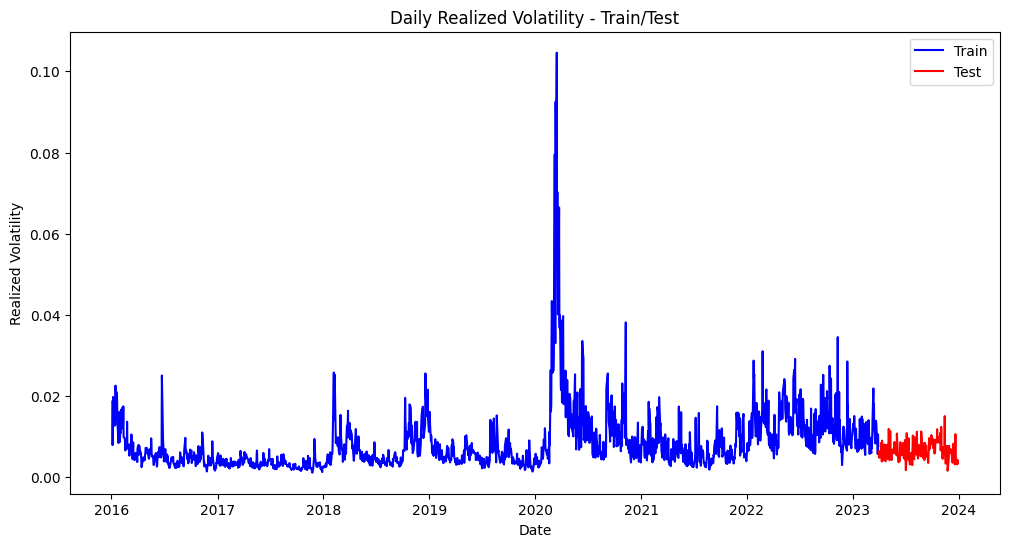

In [28]:
'''
Plot the train and test of data with different colors
'''

# Calculate the index to split data into train and test portions
split_index = int(0.9 * len(data))

# Separate data into train and test portions
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

plt.figure(figsize=(12, 6))

# Plot train and test data with different colors
plt.plot(train_data.index, train_data['Realized Volatility'], label='Train', color='blue')
plt.plot(test_data.index, test_data['Realized Volatility'], label='Test', color='red')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Realized Volatility')
plt.title('Daily Realized Volatility - Train/Test')
plt.legend()

# Save the plot as an image
plt.savefig("Outputs/Data Visualization/Realized_Volatility_train_test.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


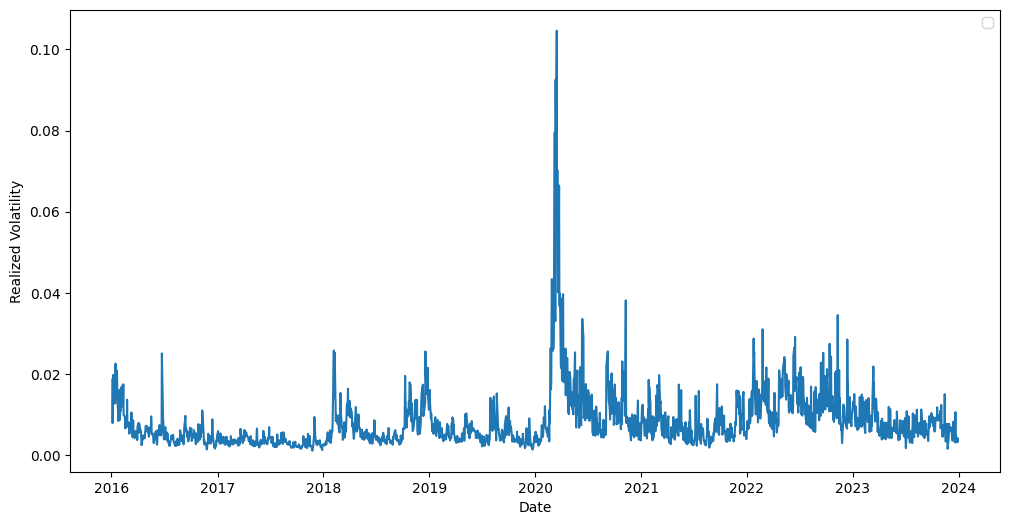

In [29]:
'''
Plot the realized volatility only
'''
# Plot train and test data with different colors
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Realized Volatility'])

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Realized Volatility')
plt.legend()
plt.savefig("Outputs/Data Visualization/Realized_Volatility_without_title.png")

Data Preprocessing: Stationarity Test and data transformation

In [30]:
'''
We will check the stationarity of the data using the Augmented Dickey-Fuller test
'''
def adf_test(data):
    for column in data.columns:
        result = adfuller(data[column])
        print(f'Stationarity Test for {column}:')
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        print('\n')

adf_test(data)

Stationarity Test for Realized Volatility:
ADF Statistic: -4.846200
p-value: 0.000044
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for Return:
ADF Statistic: -13.498458
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for ADS:
ADF Statistic: -5.567857
p-value: 0.000001
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for US Policy Index:
ADF Statistic: -3.935627
p-value: 0.001788
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for 13w TB:
ADF Statistic: 0.314315
p-value: 0.977992
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for VIX:
ADF Statistic: -4.524938
p-value: 0.000177
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for Dollar_index:
ADF Statistic: -1.687182
p-value: 0.437728
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for term_spread:
ADF Statistic: -0.921434
p-value: 0.7808

In [31]:
'''
Three columns are not stationary: Dollar_index, term_spread, and 13w TB.
We get the log returns of these columns and drop the original columns.
'''
columns_to_replace_with_returns = ['Dollar_index', 'term_spread', '13w TB']
for column in columns_to_replace_with_returns:
    data[column+'_ret'] = np.log(data[column] / data[column].shift(1))
    data.drop(column, axis=1, inplace=True)
    data.dropna(inplace=True)
    
data.head()

,Realized Volatility,Return,ADS,US Policy Index,VIX,Volume,Sentiment Score,Dollar_index_ret,term_spread_ret,13w TB_ret
2016-01-07,0.019777,-0.024133,-0.250960,56.40,24.990000,5076590000,0.033178,-0.009727,-0.016045,-0.075986
2016-01-08,0.013277,-0.011079,-0.237233,62.21,27.010000,4664940000,-0.001335,0.003253,-0.024200,0.000000
2016-01-11,0.012732,0.000874,-0.198630,65.10,24.299999,4607290000,0.000000,0.001926,0.009322,-0.082238
2016-01-12,0.013360,0.007985,-0.186875,67.32,22.469999,4887260000,0.000000,0.002428,-0.054266,0.182322
2016-01-13,0.014332,-0.025365,-0.175703,130.12,25.219999,5087030000,0.018311,-0.000404,-0.025183,0.023531


In [32]:
'''
Check the stationarity of the data after the transformation: All columns are stationary
'''

adf_test(data)

Stationarity Test for Realized Volatility:
ADF Statistic: -5.546992
p-value: 0.000002
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for Return:
ADF Statistic: -12.106903
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for ADS:
ADF Statistic: -5.458567
p-value: 0.000003
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for US Policy Index:
ADF Statistic: -4.007853
p-value: 0.001370
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for VIX:
ADF Statistic: -4.613647
p-value: 0.000122
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for Volume:
ADF Statistic: -4.123779
p-value: 0.000884
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for Sentiment Score:
ADF Statistic: -2.080912
p-value: 0.252259
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Stationarity Test for Dollar_index_ret:
ADF Statistic: -42.513577
p-val

In [33]:
'''
Save the stationary data
'''
data.to_csv("Data/raw_data_stationary.csv")

In [34]:
data_stationary_lag1 = add_lags(data, data.columns, [1], ['Realized Volatility'])
data_stationary_lag1.to_csv("Data/raw_data_stationary_with_one_lag.csv")

In [35]:
data_stationary_lag1.head()

,Realized Volatility,Realized Volatility_lag_1,Return_lag_1,ADS_lag_1,US Policy Index_lag_1,VIX_lag_1,Volume_lag_1,Sentiment Score_lag_1,Dollar_index_ret_lag_1,term_spread_ret_lag_1,13w TB_ret_lag_1
2016-01-08,0.013277,0.019777,-0.024133,-0.250960,56.40,24.990000,5.076590e+09,0.033178,-0.009727,-0.016045,-0.075986
2016-01-11,0.012732,0.013277,-0.011079,-0.237233,62.21,27.010000,4.664940e+09,-0.001335,0.003253,-0.024200,0.000000
2016-01-12,0.013360,0.012732,0.000874,-0.198630,65.10,24.299999,4.607290e+09,0.000000,0.001926,0.009322,-0.082238
2016-01-13,0.014332,0.013360,0.007985,-0.186875,67.32,22.469999,4.887260e+09,0.000000,0.002428,-0.054266,0.182322
2016-01-14,0.012763,0.014332,-0.025365,-0.175703,130.12,25.219999,5.087030e+09,0.018311,-0.000404,-0.025183,0.023531


In [36]:
'''
We see that the correlation between the realized volatility with absolute return is higher than the correlation with return.
'''

correlation = data['Realized Volatility'].corr(data['Return'])
correlation_abs = data['Realized Volatility'].corr(np.abs(data['Return']))

print(correlation)
print(correlation_abs)

-0.2154875759170353
0.744127971389226


In [37]:
# Remove the Return column and add the Abs Return column
data['Abs Return'] = np.abs(data['Return'])
data.drop('Return', axis=1, inplace=True)

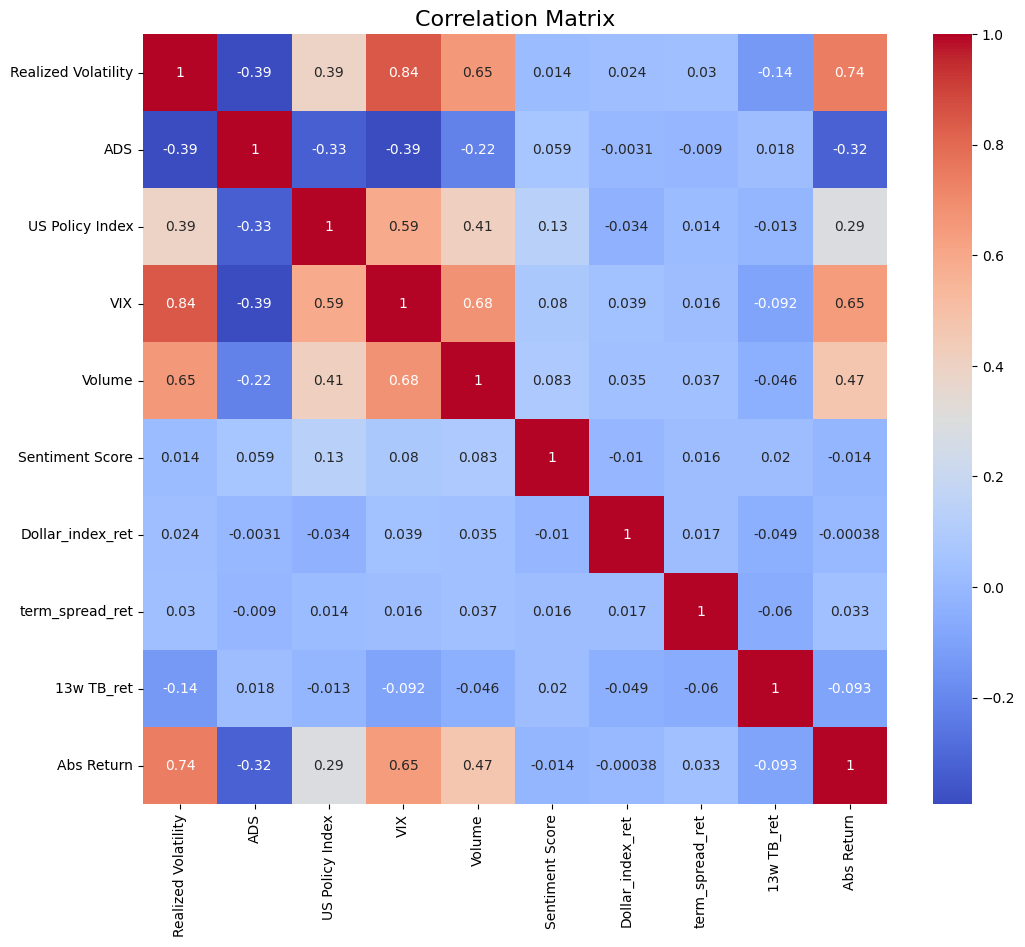

In [40]:
'''
Plot the heatmap of the correlation matrix
'''

plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=16)

plt.savefig("Outputs/Data Visualization/heatmap.png", bbox_inches = 'tight')


In [41]:
'''
Replace the Sentiment Score with its absolute value
'''
data['Sentiment Score'] = np.abs(data['Sentiment Score'])

In [42]:
'''
Save the data with absolute return
'''
data.to_csv("Data/raw_data_stationary_abs_return.csv")

In [43]:
data_stationary_abs_lag1 = add_lags(data, data.columns, [1], ['Realized Volatility'])
data_stationary_abs_lag1.to_csv("Data/raw_data_stationary_abs_return_with_one_lag.csv")

Feature Selection with Backward Elimination

In [108]:
data = pd.read_csv("Data/raw_data_stationary_abs_return.csv", index_col=0, parse_dates=True)
data.head()

,Realized Volatility,ADS,US Policy Index,VIX,Volume,Sentiment Score,Dollar_index_ret,term_spread_ret,13w TB_ret,Abs Return
2016-01-07,0.019777,-0.250960,56.40,24.990000,5076590000,0.033178,-0.009727,-0.016045,-0.075986,0.024133
2016-01-08,0.013277,-0.237233,62.21,27.010000,4664940000,0.001335,0.003253,-0.024200,0.000000,0.011079
2016-01-11,0.012732,-0.198630,65.10,24.299999,4607290000,0.000000,0.001926,0.009322,-0.082238,0.000874
2016-01-12,0.013360,-0.186875,67.32,22.469999,4887260000,0.000000,0.002428,-0.054266,0.182322,0.007985
2016-01-13,0.014332,-0.175703,130.12,25.219999,5087030000,0.018311,-0.000404,-0.025183,0.023531,0.025365


In [101]:
'''
Adding the second power of the first lag as data augmentation
'''
def add_powers(data, columns, powers):
    for column in columns:
        for power in powers:
            data[column + '_power_' + str(power)] = data[column] ** power
    return data

In [109]:
# Adding lags
data = add_lags(data, data.columns, [1, 2], ['Realized Volatility'])
data.head()

,Realized Volatility,Realized Volatility_lag_1,Realized Volatility_lag_2,ADS_lag_1,ADS_lag_2,US Policy Index_lag_1,US Policy Index_lag_2,VIX_lag_1,VIX_lag_2,Volume_lag_1,...,Sentiment Score_lag_1,Sentiment Score_lag_2,Dollar_index_ret_lag_1,Dollar_index_ret_lag_2,term_spread_ret_lag_1,term_spread_ret_lag_2,13w TB_ret_lag_1,13w TB_ret_lag_2,Abs Return_lag_1,Abs Return_lag_2
2016-01-11,0.012732,0.013277,0.019777,-0.237233,-0.250960,62.21,56.40,27.010000,24.990000,4.664940e+09,...,0.001335,0.033178,0.003253,-0.009727,-0.024200,-0.016045,0.000000,-0.075986,0.011079,0.024133
2016-01-12,0.013360,0.012732,0.013277,-0.198630,-0.237233,65.10,62.21,24.299999,27.010000,4.607290e+09,...,0.000000,0.001335,0.001926,0.003253,0.009322,-0.024200,-0.082238,0.000000,0.000874,0.011079
2016-01-13,0.014332,0.013360,0.012732,-0.186875,-0.198630,67.32,65.10,22.469999,24.299999,4.887260e+09,...,0.000000,0.000000,0.002428,0.001926,-0.054266,0.009322,0.182322,-0.082238,0.007985,0.000874
2016-01-14,0.012763,0.014332,0.013360,-0.175703,-0.186875,130.12,67.32,25.219999,22.469999,5.087030e+09,...,0.018311,0.000000,-0.000404,0.002428,-0.025183,-0.054266,0.023531,0.182322,0.025365,0.007985
2016-01-15,0.022562,0.012763,0.014332,-0.165109,-0.175703,72.92,130.12,23.950001,25.219999,5.241110e+09,...,0.005937,0.018311,0.001616,-0.000404,-0.011660,-0.025183,0.110001,0.023531,0.016282,0.025365


In [103]:
data.to_csv("Data/raw_data_stationary_abs_return_with_two_lags.csv")

In [104]:
# adding the second power of the first lag
columns_to_add_power = []
for column in data.columns:
    if 'lag_1' in column:
        columns_to_add_power.append(column)
add_powers(data, columns_to_add_power, [2])
data.head()

,Realized Volatility,Realized Volatility_lag_1,Realized Volatility_lag_2,ADS_lag_1,ADS_lag_2,US Policy Index_lag_1,US Policy Index_lag_2,VIX_lag_1,VIX_lag_2,Volume_lag_1,...,Realized Volatility_lag_1_power_2,ADS_lag_1_power_2,US Policy Index_lag_1_power_2,VIX_lag_1_power_2,Volume_lag_1_power_2,Sentiment Score_lag_1_power_2,Dollar_index_ret_lag_1_power_2,term_spread_ret_lag_1_power_2,13w TB_ret_lag_1_power_2,Abs Return_lag_1_power_2
2016-01-11,0.012732,0.013277,0.019777,-0.237233,-0.250960,62.21,56.40,27.010000,24.990000,4.664940e+09,...,0.000176,0.056279,3870.0841,729.540112,2.176167e+19,0.000002,1.058001e-05,0.000586,0.000000,1.227518e-04
2016-01-12,0.013360,0.012732,0.013277,-0.198630,-0.237233,65.10,62.21,24.299999,27.010000,4.607290e+09,...,0.000162,0.039454,4238.0100,590.489963,2.122712e+19,0.000000,3.710706e-06,0.000087,0.006763,7.635716e-07
2016-01-13,0.014332,0.013360,0.012732,-0.186875,-0.198630,67.32,65.10,22.469999,24.299999,4.887260e+09,...,0.000178,0.034922,4531.9824,504.900869,2.388531e+19,0.000000,5.894701e-06,0.002945,0.033241,6.376030e-05
2016-01-14,0.012763,0.014332,0.013360,-0.175703,-0.186875,130.12,67.32,25.219999,22.469999,5.087030e+09,...,0.000205,0.030872,16931.2144,636.048365,2.587787e+19,0.000335,1.634212e-07,0.000634,0.000554,6.433776e-04
2016-01-15,0.022562,0.012763,0.014332,-0.165109,-0.175703,72.92,130.12,23.950001,25.219999,5.241110e+09,...,0.000163,0.027261,5317.3264,573.602537,2.746923e+19,0.000035,2.611322e-06,0.000136,0.012100,2.651126e-04


In [ ]:
data.to_csv("Data/raw_data_stationary_abs_return_with_two_lags_and_powers.csv")

In [110]:
'''
Applying backward elimination on the augmented data to select the most important features. After the selection, 2 columns are dropped: Dollar_index_ret_lag_1, term_spread_ret_lag_1
'''

def backwardElimination(x, y, sl, columns):
    numVars = x.shape[1]
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j] == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                   
    regressor_OLS.summary()
    return x, columns

# We apply the selection on the train data only 
test_data = data.iloc[-int(len(data) * 0.1):]
train_data = data.iloc[:-int(len(data) * 0.1)]

test_X = test_data.iloc[:,1:]
test_y = test_data.iloc[:,0:1]

train_X = train_data.iloc[:,1:]
train_y = train_data.iloc[:,0:1]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = pd.DataFrame(scaler_X.fit_transform(train_X), columns=train_X.columns)
y = pd.DataFrame(scaler_y.fit_transform(train_y.values.reshape(-1, 1)), columns=['Realized Volatility'])
X['constant'] = 1

SL = 0.05
X , important_features2  = backwardElimination(train_X.values, train_y.values, SL, train_X.columns)

important_features2 = list(important_features2) 

print('The selected columns are:', important_features2)

The selected columns are: ['Realized Volatility_lag_1', 'Realized Volatility_lag_2', 'US Policy Index_lag_1', 'VIX_lag_1', 'Volume_lag_2', 'term_spread_ret_lag_2', '13w TB_ret_lag_1', '13w TB_ret_lag_2', 'Abs Return_lag_1']


In [112]:
important_features2 = ["Realized Volatility"] + important_features2 + ["Sentiment Score_lag_1"]
data = data[important_features2]
data.tail()

,Realized Volatility,Realized Volatility_lag_1,Realized Volatility_lag_2,US Policy Index_lag_1,VIX_lag_1,Volume_lag_2,term_spread_ret_lag_2,13w TB_ret_lag_1,13w TB_ret_lag_2,Abs Return_lag_1,Sentiment Score_lag_1
2023-12-22,0.005164,0.010610,0.006980,95.99,13.65,4.201320e+09,0.038336,-0.003831,-0.001528,0.010436,0.190478
2023-12-26,0.003196,0.005164,0.010610,52.02,13.03,3.431180e+09,-0.020865,-0.000384,-0.003831,0.001606,0.157128
2023-12-27,0.004119,0.003196,0.005164,111.18,12.99,3.046770e+09,0.000753,-0.000961,-0.000384,0.004151,0.141046
2023-12-28,0.003188,0.004119,0.003196,145.72,12.43,2.513910e+09,-0.000753,0.006131,-0.000961,0.001582,0.165051
2023-12-29,0.004105,0.003188,0.004119,168.59,12.47,2.748450e+09,0.080969,-0.003253,0.006131,0.000339,0.178850


In [113]:
data.to_csv("Data/data_with_lags_and_sentiment_feature_selected.csv")